In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

In [2]:
df = pd.read_parquet('/Users/max/sync/cornell/2021_FA_Final_Project/spoke/pipeline_data/2019_thru_2021/train.parquet')

In [3]:
crashes = df.query('IS_CRASH == 1')
non_crashes = df.query('IS_CRASH == 0').sample(n=10_000)
cols_to_drop = [
    'IS_CRASH',
    'WT10',
    'WT13',
    'WT14',
    'WT15',
    'WT16',
    'WT18',
    'WT19',
    'WT22',
    ]

df_trunc = pd.concat((crashes, non_crashes))
X = df_trunc.drop(columns=cols_to_drop)
y = df_trunc.IS_CRASH

In [4]:
df_eval = pd.read_parquet('/Users/max/sync/cornell/2021_FA_Final_Project/spoke/pipeline_data/2019_thru_2021/eval.parquet')
X_eval = df_eval.drop(columns=cols_to_drop)
y_eval = df_eval.IS_CRASH

In [5]:
# Fixed parameter values below were determined by previous passes of grid search
dtc = RandomForestClassifier(max_samples=0.8, random_state=42, n_jobs=-1)
model = HalvingGridSearchCV(dtc, {
    'max_depth': list(range(12, 25)),
}, scoring='roc_auc', n_jobs=-1, verbose=1)

In [6]:
model.fit(X, y)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1329
max_resources_: 11967
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 13
n_resources: 1329
Fitting 5 folds for each of 13 candidates, totalling 65 fits
----------
iter: 1
n_candidates: 5
n_resources: 3987
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 2
n_resources: 11961
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=RandomForestClassifier(max_samples=0.8, n_jobs=-1,
                                                     random_state=42),
                    n_jobs=-1,
                    param_grid={'max_depth': [12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24]},
                    scoring='roc_auc', verbose=1)

In [7]:
model.best_score_

0.7144679628589022

In [8]:
model.best_params_

{'max_depth': 13}

Let's recap here. So the ROC AUC Score is basically plotting our True Positive Rate (TPR; the fraction of rows that we predict to be crashes that are in fact crashes) against our False Positive Rate (FPR; the fraction of rows that we predict to be crashes that are not in fact crashes), as you vary the "discrimination threshold". The area under that curve is the score that we receive.


What is the "discrimination threshold"? It's the decision boundary. Oh I see I see. It's basically representing the tradeoff between a more permissive discrimination threshold and a less permissive one. As you move to the right on the X-axis, the FPR is going up, meaning that you're classifying more things as positive that you shouldn't be. You'd expect that your Y-axis should go up as you do that too—you want to be classifying more positive things correctly too. If you just classify everything as true, you end up with a TPR and an FPR of 1.

So the best models would get you to a very high TPR while keeping you at a low FPR. In other words, you'd model a decision boundary that is able to correctly classify everything. Duh. The best possible model would just be a point at TPR=1, FPR=0.

What I don't quite understand is how this translates to a notion of "area"? How, for a given model, can I compute the ROC AUC score? Is it just taking y-value of that specific decision boundary? In other words, just the TPR? That doesn't seem to make any sense to me.

Here's another interpretationg offered from Google: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
> "One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example."

In [9]:
roc_auc_score(y_eval, model.predict_proba(X_eval)[:, 1])

0.7477701785589606

This is saying that "for any given crash event in the dataset, there is a 74.5% chance that we would predict it to have a higher probability of being a crash than we would for any given non-crash event in the dataset."

Cool, so with that intepretation the result we're seeing from the cross validation now makes total sense. The best it was able to do on the cross-validation set was a score of ~73%. We also got a score of 75.5% on our own validation set.

Let's now look at which features the classifier learned to find important. These features are ranked by their ability to reduce the size of the overall criterion.

In [10]:
pd.Series(model.best_estimator_.feature_importances_, index=model.best_estimator_.feature_names_in_).sort_values(ascending=False).head(n=15)

EVENT_TIME     0.192903
EVENT_DATE     0.102784
TAVG           0.097370
AWND           0.088331
PRCP           0.087484
PGTM           0.086433
primary        0.064995
secondary      0.045027
cycleway       0.040701
residential    0.038859
SNWD           0.038353
service        0.012716
WT08           0.012277
tertiary       0.011719
SNOW           0.011681
dtype: float64

<AxesSubplot:>

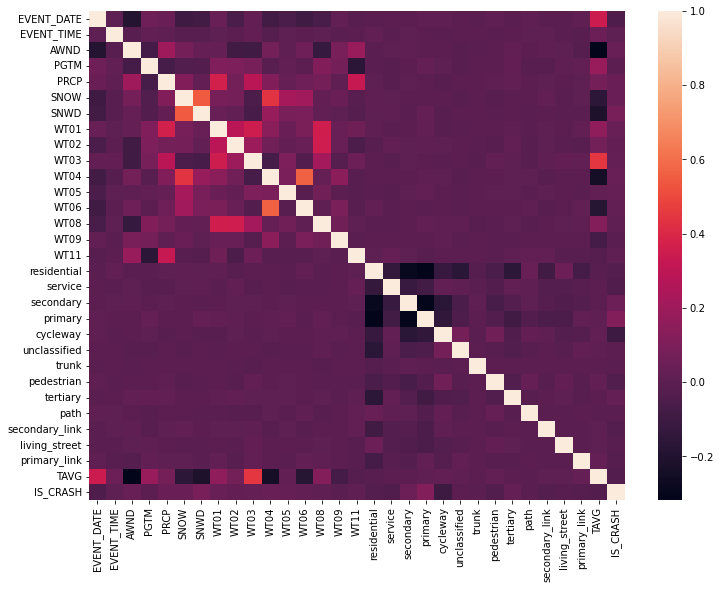

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(12, 9))
sns.heatmap(pd.concat((X, y), axis=1).corr())